# Build an app for public health

## <i>Data exploration</i>

My mission here for <strong>Santé publique France</strong> is to create an application related to food from the [Open Food Fact dataset](https://world.openfoodfacts.org/).<br>

I want to offer a French application which, when entering the product or product category of your choice, will offer a top 3 of the most recommended brands in terms of nutritional quality.<br>
The app name is : <i><strong>Buy Better</strong></i><br>
<br>
In the first part we cleaned and increased the data of our dataset.<br>
In this part we will:
<li>produce visualizations to better understand the data,</li>
<li>perform a univariate analysis for each variable of interest to synthesize its behavior,</li>
<li>confirm or refute the hypotheses using a multivariate analysis,</li>
<li>perform the appropriate statistical tests to verify the significance of the results.</li>

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools </strong> [(here)](#another_cell_0)<br>
 
<strong>II. <i>Buy better</i> : data exploration</strong><br>
     -- A. Univariate analysis [(here)](#another_cell_a)<br>
     ---- <i>a. Analysis of the nutrition_grade_fr variable</i> [(here)](#another_cell_b)<br>
     ---- <i>b. Analysis of the variable saturated-fat_100g</i> [(here)](#another_cell_c)<br>
     ---- <i>c. Analysis of the additives_n variable</i> [(here)](#another_cell_d)<br>
     -- B. Bivariate analysis [(here)](#another_cell_e)<br>
     ---- <i>a. Correlation between nutritional grade and saturated fat</i> [(here)](#another_cell_f)<br>
     ---- <i>b. Correlation between nutritional grade and number of additives</i> [(here)](#another_cell_g)<br>
     ---- <i>c. Relationship between vitamin D levels and vitamin C levels in food products</i> [(here)](#another_cell_h)<br>
     ---- <i>d. Correlation matrix</i> [(here)](#another_cell_i)<br>
     -- C. Multivariate analysis with PCA [(here)](#another_cell_j)<br>
     ---- <i>a. Pre-processing</i> [(here)](#another_cell_k)<br>
     ---- <i>b. Explained Variance Ratio and Scree plot</i> [(here)](#another_cell_l)<br>
     ---- <i>c. Correlation circles and projections of points</i> [(here)](#another_cell_m)<br>
     -- D. Explanatory analysis with ANOVA & Kruskal-Wallis [(here)](#another_cell_n)<br>
     ---- <i>a. ANOVA test on our dependant variable "nutrition_grade_fr" for frozen products brands</i> [(here)](#another_cell_o)<br>
     ---- <i>b. Kruskal-Wallis test on "nutrition_grade_fr" for frozen products brands</i> [(here)](#another_cell_p)<br>
     ---- <i>c. ANOVA test on "additives_n" for sodas brands</i> [(here)](#another_cell_q)<br>
     ---- <i>d. Kruskal-Wallis test on "nutrition_grade_fr" for sodas</i> [(here)](#another_cell_r)<br><br>
<strong>Conclusion (part 2) </strong> [(here)](#another_cell_s)

<a id='another_cell_0'></a> 

### Tools

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import levene
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import kruskal

In [2]:
def plot_nutrition_grade_by_brand(df, brands_list):
    # Check that the selected brands are present in the DataFrame
    if not set(brands_list).issubset(set(df['brands'].unique())):
        print("Error: Some selected brands are not present in the DataFrame")
        return
    
    # Filter df for selected brands
    df = df[df['brands'].isin(brands_list)]
    
    # Convert column 'nutrition_grade_fr' to numeric variable
    grade_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
    df['nutrition_grade_num'] = df['nutrition_grade_fr'].str.lower().map(grade_map)
    
    # Plot the violinplot
    sns.violinplot(x='brands', y='nutrition_grade_fr', data=df)
    
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''Display correlation circles, one for each factorial plane'''

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialize the matplotlib figure
            #fig, ax = plt.subplots(figsize=(8,8))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialize the matplotlib figure      
            #fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            #plt.show(block=False)
            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
   

def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

## I. <i>Buy better</i> : data exploration

<a id='another_cell_a'></a>

### A. Univariate analysis

- <strong>Data set loading</strong>

In [3]:
data = pd.read_csv("data_bb_final.csv", low_memory=False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   product_name                 2466 non-null   object 
 1   main_category_fr             2466 non-null   object 
 2   brands                       2466 non-null   object 
 3   nutrition_grade_fr           2466 non-null   object 
 4   fiber_100g                   2466 non-null   float64
 5   proteins_100g                2466 non-null   float64
 6   fat_100g                     2466 non-null   float64
 7   energy_100g                  2466 non-null   float64
 8   alcohol_100g                 2466 non-null   float64
 9   carbohydrates_100g           2466 non-null   float64
 10  polyols_100g                 2466 non-null   float64
 11  saturated-fat_100g           2466 non-null   float64
 12  ingredients_from_palm_oil_n  2466 non-null   float64
 13  additives_n       

<div class="alert-success">
☛ To respond to the project, <strong>we need to keep the following variables:<br>
- product_name<br>
- main_category_fr<br>
- brands<br>
- nutrition_grade_fr<br>
- additives_n </strong>(to discriminate against products with)<br>
<strong>- ingredients_from_palm_oil_n</strong> (to discriminate against products with)<br>
<strong>- vitamin-d_100g</strong> (to discriminate positvely products with)<br>
<strong>- vitamin-c_100g</strong> (to discriminate positvely products with)<br><br>
    <i>The other are mostly related to "nutrition_grade_fr", so we can remove them from our dataset.</i>
</div>

In [5]:
# Drop other variables
data.drop(['fiber_100g','proteins_100g','fat_100g', 'energy_100g', 'alcohol_100g','carbohydrates_100g','polyols_100g','ingredients_from_palm_oil_n'], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        2466 non-null   object 
 1   main_category_fr    2466 non-null   object 
 2   brands              2466 non-null   object 
 3   nutrition_grade_fr  2466 non-null   object 
 4   saturated-fat_100g  2466 non-null   float64
 5   additives_n         2466 non-null   float64
 6   vitamin-d_100g      2466 non-null   float64
 7   vitamin-c_100g      2466 non-null   float64
dtypes: float64(4), object(4)
memory usage: 154.2+ KB


<a id='another_cell_b'></a> 

#### a. <strong>Analysis of the <i>nutrition_grade_fr</i> variable</strong>

In [7]:
# Number of values per grade
nutrition_counts = data['nutrition_grade_fr'].value_counts()
print("Number of values per grade :", "\n")
print(nutrition_counts)

Number of values per grade : 

b          834
a          600
c          537
unknown    271
d          213
e           11
Name: nutrition_grade_fr, dtype: int64


<div class="alert-warning">
☛ More than 250 products don't have any nutriscore grade
</div>

In [8]:
indexNames = data.loc[(data["nutrition_grade_fr"] == "unknown") 
         & (data["saturated-fat_100g"] == 0) 
         & (data["additives_n"] == 0) 
         & (data["vitamin-d_100g"] == 0) 
         & (data["vitamin-c_100g"] == 0)].index
print(len(indexNames), "products have no data at all, we can delete them")

97 products have no data at all, we can delete them


In [9]:
data.drop(indexNames, inplace=True)
data.shape

(2369, 8)

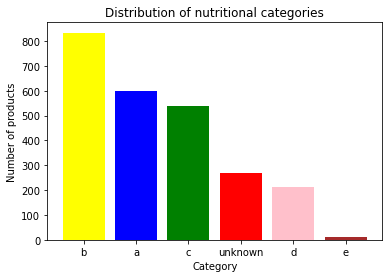

In [10]:
colors = ['yellow', 'blue', 'green', 'red', 'pink', 'brown']

plt.bar(nutrition_counts.index, nutrition_counts.values, color=colors)
plt.title('Distribution of nutritional categories')
plt.xlabel('Category')
plt.ylabel('Number of products')
plt.show()

<div class="alert-success">
☛ <strong>Nutriscores with a good nutritional grade represent more than 50% of the products in our dataset</strong>
</div>

<a id='another_cell_c'></a>

#### b. <strong>Analysis of the variable <i>saturated-fat_100g</i></strong>

In [11]:
saturated_fat_stats = data['saturated-fat_100g'].describe()
print(saturated_fat_stats)

count    2369.000000
mean        0.026600
std         0.115260
min         0.000000
25%         0.000000
50%         0.000000
75%         0.036629
max         2.000000
Name: saturated-fat_100g, dtype: float64


<div class="alert-success">
☛ <strong>More than 50% of products have no saturated fat</strong>
</div>

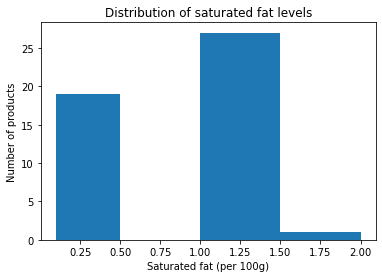

In [12]:
saturated_fat = data['saturated-fat_100g']

# Remove missing values for saturated fat
saturated_fat = saturated_fat.dropna()

# Define class intervals for histogram
bins = [0.1, 0.5, 1, 1.5, 2]

# Plot the histogram
plt.hist(saturated_fat, bins=bins)
plt.title('Distribution of saturated fat levels')
plt.xlabel('Saturated fat (per 100g)')
plt.ylabel('Number of products')
plt.show()

<div class="alert-success">
We find that there are <strong>three categories of products with saturated fat</strong>:<br>
- products with between 0g and 0.5g of saturated fat<br>
- products with between 1g and 1.5g of saturated fat<br>
- products with more than 1.5g of saturated fat<br>
<strong><i>☛ It is possible to assign a different negative weighting score to each of these categories</i></strong>
</div>

<a id='another_cell_d'></a>

#### c. <strong>Analysis of the <i>additives_n</i> variable</strong>

In [13]:
data["additives_n"].describe()

count    2369.000000
mean        1.220346
std         2.124799
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        18.000000
Name: additives_n, dtype: float64

<div class="alert-success">
☛ <strong>More than 50% of products have no additives</strong>
</div>

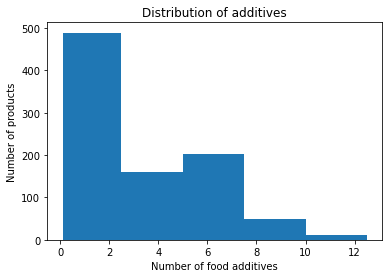

In [14]:
additives_n = data['additives_n']

# Remove missing values for saturated fat
additives_n = additives_n.dropna()

# Define class intervals for histogram
bins = [0.1, 2.5, 5, 7.5, 10, 12.5]

# Plot the histogram
plt.hist(additives_n, bins=bins)
plt.title('Distribution of additives')
plt.xlabel('Number of food additives')
plt.ylabel('Number of products')
plt.show()

<div class="alert-success">
We find that there are <strong>five categories of products with additives</strong>:<br>
- products with between 0 and 2 food additives<br>
- products with between 2 and 5 food additives<br>
- products with between 5 and 7 food additives<br>
- products with between 8 and 10 food additives<br>
- products with more than 10 food additives<br>
<strong><i>☛ It is possible to assign a different negative weighting score to each of these categories</i></strong>
</div>

<a id='another_cell_e'></a>

### B. Bivariate analysis

<a id='another_cell_f'></a>

#### a. <strong>Correlation between nutritional grade and saturated fat</strong>

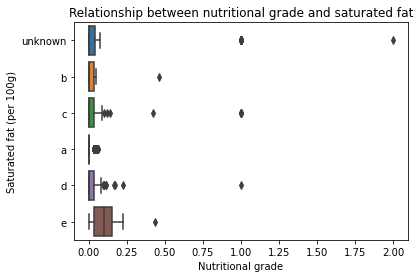

In [15]:
sns.boxplot(x="saturated-fat_100g", y="nutrition_grade_fr", data=data)
plt.title("Relationship between nutritional grade and saturated fat")
plt.xlabel("Nutritional grade")
plt.ylabel("Saturated fat (per 100g)")
plt.show()

<div class="alert-success">
<strong>☛ There is obviously a correlation between nutritional grade and level of saturated fat</strong> : the lower the nutritional grade, the more saturated fat there is in a product
</div>

<a id='another_cell_g'></a>

#### b. <strong>Correlation between nutritional grade and number of additives</strong>

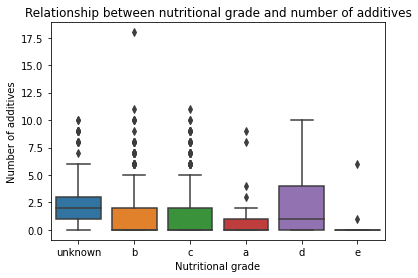

In [16]:
# Relationship between nutritional grade and number of additives
sns.boxplot(x="nutrition_grade_fr", y="additives_n", data=data)
plt.title("Relationship between nutritional grade and number of additives")
plt.xlabel("Nutritional grade")
plt.ylabel("Number of additives")
plt.show()

<div class="alert-success">
<strong>☛ There is obviously a correlation between nutritional grade and number of food additives</strong> : the lower the nutritional grade, the more food additives there are in a product
</div>

<a id='another_cell_h'></a>

#### c. <strong>Relationship between vitamin D levels and vitamin C levels in food products</strong>

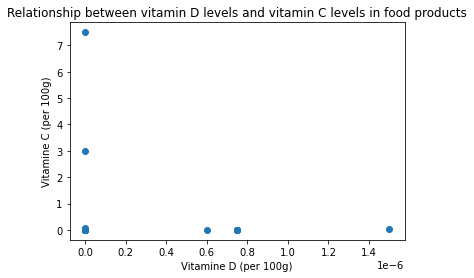

In [17]:
# Select columns for vitamin D and vitamin C
vitamins_data = data[['vitamin-d_100g', 'vitamin-c_100g']]

# Delete rows containing missing values for these two columns
vitamins_data = vitamins_data.dropna()

# Plot the scatter plot
plt.scatter(x=vitamins_data['vitamin-d_100g'], y=vitamins_data['vitamin-c_100g'])
plt.title('Relationship between vitamin D levels and vitamin C levels in food products')
plt.xlabel('Vitamine D (per 100g)')
plt.ylabel('Vitamine C (per 100g)')
plt.show()

<div class="alert-success">
<strong>☛ There is no correlation between vitamine c and d</strong>
</div>

<a id='another_cell_i'></a>

#### d. <strong>Correlation matrix</strong>

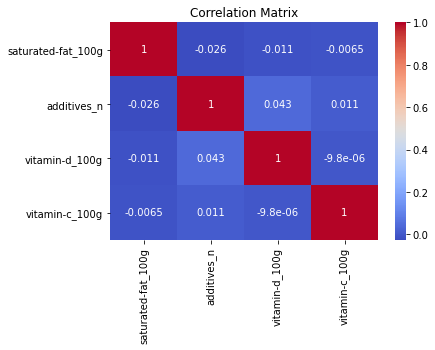

In [18]:
# Select the numerical columns
num_cols = ['saturated-fat_100g', 'additives_n', 'vitamin-d_100g', 'vitamin-c_100g']

# Create the correlation matrix
corr_matrix = data[num_cols].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<div class="alert-success">
There is no strong correlation between the variables, which means that the variables are relatively independent of each other.<br>
<strong> ☛ This suggests that each of these variables can provide unique information for the Buy Better app creation project.</strong>
</div>

<a id='another_cell_j'></a>

### C. Multivariate analysis with PCA

<a id='another_cell_k'></a>

#### a. <strong>Pre-processing</strong>

In [19]:
X = data.groupby(by="product_name").sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries,  coeurs de palmier sauvage bio 250 g net egoutte to œufs de truite bio
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   saturated-fat_100g  1946 non-null   float64
 1   additives_n         1946 non-null   float64
 2   vitamin-d_100g      1946 non-null   float64
 3   vitamin-c_100g      1946 non-null   float64
dtypes: float64(4)
memory usage: 76.0+ KB


In [20]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check
pd.DataFrame(X_scaled, columns=X.columns).describe().round(2)

,saturated-fat_100g,additives_n,vitamin-d_100g,vitamin-c_100g
count,1946.00,1946.00,1946.00,1946.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-0.23,-0.47,-0.05,-0.03
25%,-0.23,-0.47,-0.05,-0.03
50%,-0.23,-0.47,-0.05,-0.03
75%,0.03,0.16,-0.05,-0.03
max,14.21,13.67,30.00,40.94


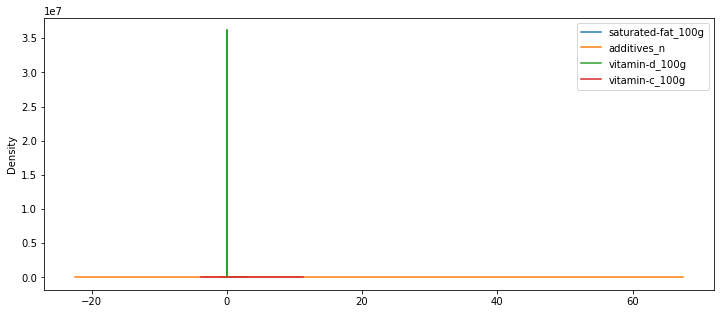

In [21]:
# Before standardisation
X1 = pd.DataFrame(X,columns=X.columns)
X1.plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

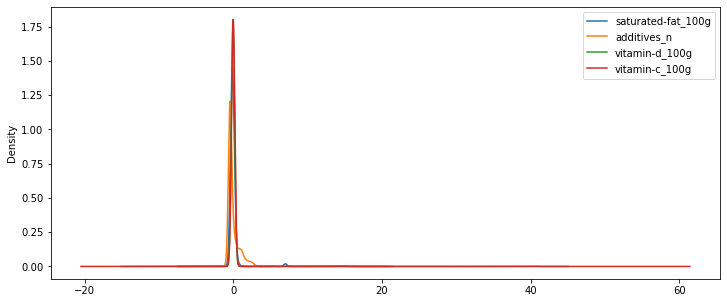

In [22]:
# After standardisation
pd.DataFrame(X_scaled,columns=X.columns).plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

In [23]:
X_transformed = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_transformed = X_transformed.reset_index()
X_transformed

,product_name,saturated-fat_100g,additives_n,vitamin-d_100g,vitamin-c_100g
0,coeurs de palmier sauvage bio 250 g net egoutte,0.039830,-0.466731,-0.052514,-0.031524
1,green ice tea agrumes,0.030665,-0.466731,-0.052514,-0.031524
2,iced tea peche,0.035248,-0.466731,-0.052514,-0.031524
3,melange fraicheur le sachet de 125 g,0.035248,-0.466731,-0.052514,-0.031524
4,100 pur jus tomate,-0.233861,-0.466731,-0.052514,-0.031524
...,...,...,...,...,...
1941,épinards en branches en portions,0.030665,-0.466731,-0.052514,-0.031524
1942,épinards hachés,-0.233861,-0.466731,-0.052514,-0.031524
1943,épinards hâchés,0.030665,-0.466731,-0.052514,-0.031524
1944,épis de maïs,-0.233861,-0.466731,-0.052514,-0.031524


<a id='another_cell_l'></a>

#### b. <strong>Explained Variance Ratio and Scree plot</strong>

In [24]:
# Create the PCA model
model_pca = PCA()

# Fit the model with the data
X_reduced = model_pca.fit_transform(X_scaled)

In [25]:
# Explained variance ratio
model_pca.explained_variance_ratio_.round(2)

array([0.26, 0.25, 0.25, 0.24])

In [26]:
# Explained variance ratio cumsum
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.26, 0.51, 0.76, 1.  ])

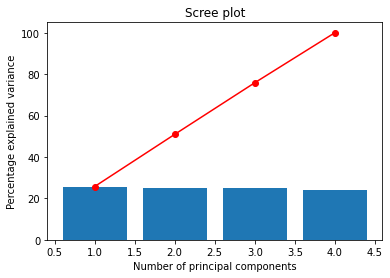

In [27]:
# Scree plot
display_scree_plot(model_pca) 

<div class="alert-success">
<i><strong>☛ The scree plot shows an even distribution of the distribution, this means that the data is evenly distributed and there are no values that occur more frequently than others. This can be thought of as a random or uniform distribution.</strong></i></br>

In [232]:
# Number of components to study
num_components = 4
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]
pc3 = model_pca.components_[2]
pc4 = model_pca.components_[3]

In [29]:
X.columns

Index(['saturated-fat_100g', 'additives_n', 'vitamin-d_100g',
       'vitamin-c_100g'],
      dtype='object')

In [30]:
pc1

array([-0.07232182,  0.69311829,  0.70263417,  0.14374216])

In [31]:
pc2

array([-0.80678394, -0.26447208,  0.07073351,  0.52359427])

In [32]:
pc3

array([ 0.43877492,  0.19641201, -0.31592788,  0.81797828])

In [33]:
pc4

array([ 0.38903186, -0.64114263,  0.63363362,  0.18999675])

<a id='another_cell_m'></a>

#### c. <strong>Correlation circles and projections of points</strong>

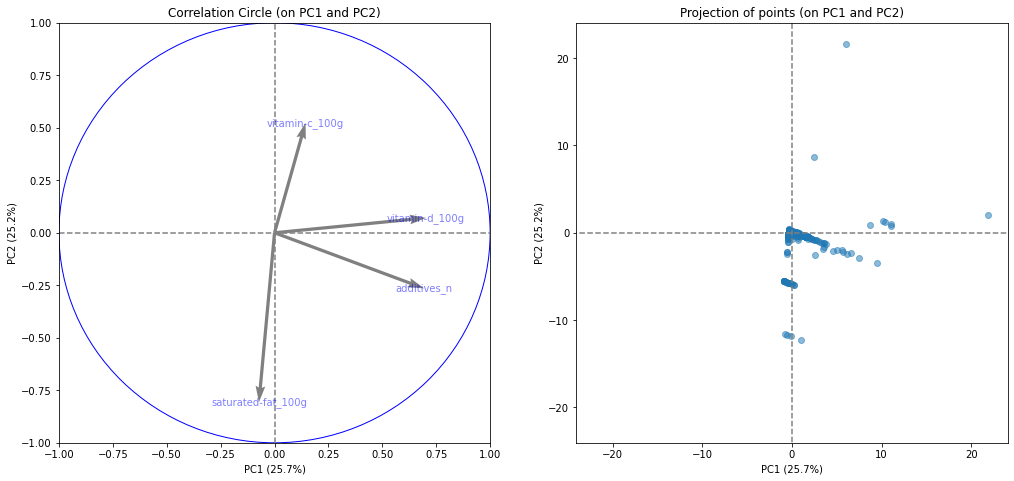

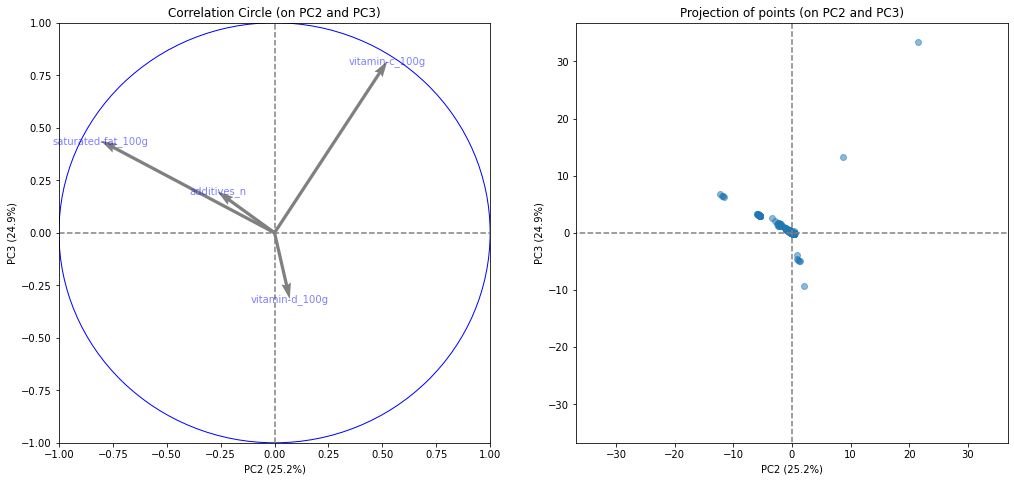

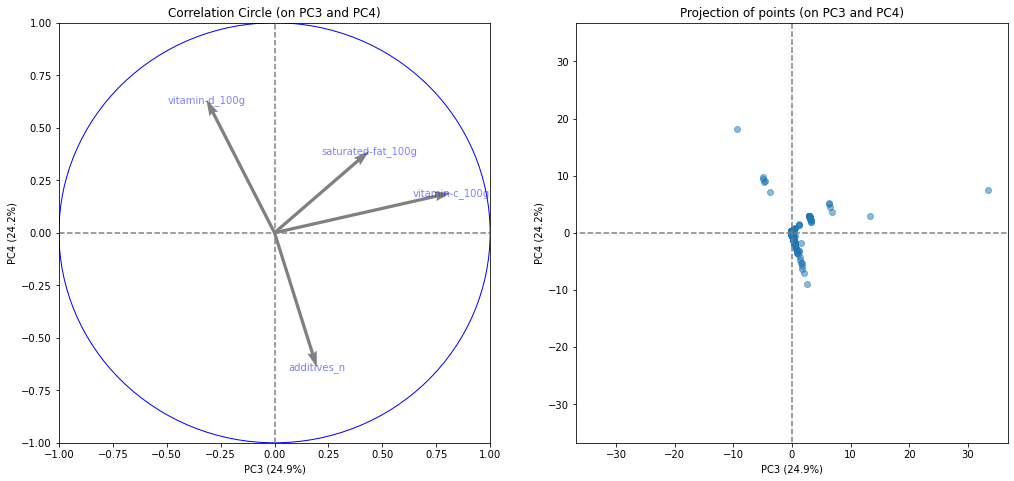

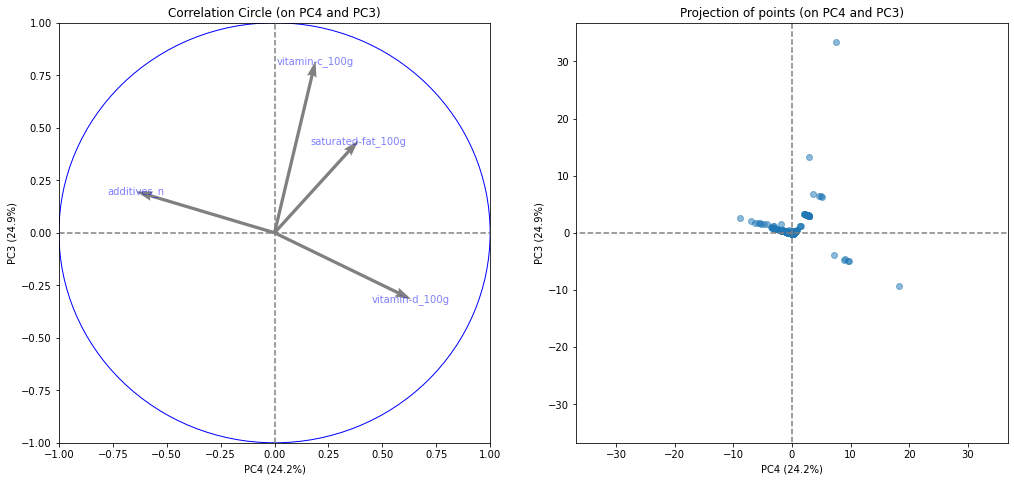

In [235]:
X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(1,2)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(1,2)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(2,3)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(2,3)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(3,2)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(3,2)], alpha = 0.5)
plt.show()

<div class="alert-success">
    <u>Axes interpretation</u> :
<i><br><li><strong> pc1</strong> → Products with a lot of additives and vitamin D
<li><strong> pc2</strong> → Fairly healthy products with mainly vitamins C and D
<li><strong> pc3</strong> → Products high in saturated fat and vitamin C
<li><strong> pc4</strong> → Products high in saturated fat and vitamin D<br>
<strong>☛ Products in our dataset can contain both vitamins (positively weighted) and additives/saturated fats (negatively weighted).<br>
☛ There don't seem to be many additive/saturated fat only products in our dataset.</strong>
</i></div>

<a id='another_cell_n'></a>

### D. Explanatory analysis with ANOVA & Kruskal-Wallis

We are now going to verify if there are significant differences between brands in the same product category: <u>frozen products</u> and <u>sodas</u>.<br>
We will use ANOVA and Kruskal-Wallis tests to verify these assumptions.<br>
☛ For this, we will have to convert our dependent variable "nutrition_grade_fr" into a numeric variable and filter our dataframe only on the main category "surgelés" and after on the main category "sodas".

In [53]:
# values mapping
mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'unknown': 0}

# "nutrition_grade_fr" variable conversion into numeric
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].replace(mapping)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2369 entries, 0 to 2465
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        2369 non-null   object 
 1   main_category_fr    2369 non-null   object 
 2   brands              2369 non-null   object 
 3   nutrition_grade_fr  2369 non-null   int64  
 4   saturated-fat_100g  2369 non-null   float64
 5   additives_n         2369 non-null   float64
 6   vitamin-d_100g      2369 non-null   float64
 7   vitamin-c_100g      2369 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 231.1+ KB


In [148]:
# Filter our dataframe only on frozen products
frozen_prod_data = data.loc[data['main_category_fr'] == 'surgelés']

In [193]:
# Filter our dataframe only on sodas
sodas_data = data.loc[data['main_category_fr'] == 'sodas']

<a id='another_cell_o'></a>

#### a. <strong>ANOVA test on our dependant variable "nutrition_grade_fr" for frozen products</strong>

In [171]:
# Creation of data groups for each frozen products brand
carrefour_nut = frozen_prod_data[frozen_prod_data['brands'] == 'carrefour']['nutrition_grade_fr']
picard_nut = frozen_prod_data[frozen_prod_data['brands'] == 'picard']['nutrition_grade_fr']
leader_price_nut = frozen_prod_data[frozen_prod_data['brands'] == 'leader price']['nutrition_grade_fr']
u_nut = frozen_prod_data[frozen_prod_data['brands'] == 'u']['nutrition_grade_fr']

In [181]:
# Levene test to verify homogeneity of groups variances
stat, p = stats.levene(carrefour_nut, picard_nut, leader_price_nut, u_nut)
print('Levene test : statistic = {}, p-value = {}'.format(stat, p))

Levene test : statistic = 0.5161290322580645, p-value = 0.67895593237459


☛ For a significance threshold defined at 0.05, the p-value is higher : the variances of the 4 groups are similar, so the assumption of homogeneity of variances is verified</strong>

In [176]:
# Shapiro-Wilk tests to verify the assumption of normality of the residuals
stat, p = stats.shapiro(carrefour_nut)
print('Shapiro-Wilk test Carrefour frozen products : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(picard_nut)
print('Shapiro-Wilk test Picard frozen products : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(leader_price_nut)
print('Shapiro-Wilk test Leader price frozen products : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(u_nut)
print('Shapiro-Wilk test U frozen products : statistic = {}, p-value = {}'.format(stat, p))

Shapiro-Wilk test Carrefour frozen products : statistic = 1.0, p-value = 1.0
Shapiro-Wilk test Picard frozen products : statistic = 0.5521817207336426, p-value = 0.00013097839837428182
Shapiro-Wilk test Leader price frozen products : statistic = 0.6297762393951416, p-value = 0.001240724348463118
Shapiro-Wilk test U frozen products : statistic = 1.0, p-value = 1.0


☛ For a significance threshold defined at 0.05, the p-value is not higher for all brands : the residuals follow a normal distribution and the assumption of normality of the residuals is only verified for Carrefour and U frozen products

In [183]:
# ANOVA test
stat, p = stats.f_oneway(carrefour_nut, picard_nut, leader_price_nut, u_nut)
print('ANOVA test : statistic = {}, p-value = {}'.format(stat, p))

ANOVA test : statistic = 1.161290322580645, p-value = 0.36481085298185667


<div class="alert-warning">
    ☛ The result of the ANOVA test indicates that the difference between the means of the groups is not statistically significant, because the p-value is greater than the commonly used level of significance of 0.05.<br>
<strong>Therefore, there is not enough evidence to conclude that frozen products brands have different nutriscore grades.</strong>
</div>

<a id='another_cell_p'></a>

#### b. <strong>Kruskal-Wallis test on our dependant variable "nutrition_grade_fr" for frozen products</strong>

Two of the four groups do not follow a normal distribution, so we can consider using an alternative to ANOVA, such as the Kruskal-Wallis test.

In [185]:
# Kruskal-Wallis test
statistic, p_value = kruskal(carrefour_nut, picard_nut, leader_price_nut, u_nut)
print("Kruskal-Wallis test: statistic =", statistic, ", p-value =", p_value)

Kruskal-Wallis test: statistic = 3.375000000000001 , p-value = 0.33733970967227644


<div class="alert-warning">
    ☛ The result of the Kruskal-Wallis test indicates that the difference between the means of the groups is not statistically significant, because the p-value is greater than the commonly used level of significance of 0.05.<br>
<strong>Therefore, there is not enough evidence to conclude that frozen products brands have different nutriscore grades here too.</strong>
</div>

<a id='another_cell_q'></a>

#### c. <strong>ANOVA test on our dependant variable "additives_n" for sodas</strong>

In [196]:
# Creation of data groups for each sodas brand
carrefour_ad = sodas_data[sodas_data['brands'] == 'carrefour']['additives_n']
leader_price_ad = sodas_data[sodas_data['brands'] == 'leader price']['additives_n']
finley_ad = sodas_data[sodas_data['brands'] == 'finley']['additives_n']
cocacola_ad = sodas_data[sodas_data['brands'] == 'cocacola']['additives_n']

In [200]:
# Levene test to verify homogeneity of groups variances
stat, p = stats.levene(carrefour_ad, leader_price_ad, finley_ad, cocacola_ad)
print('Levene test : statistic = {}, p-value = {}'.format(stat, p))

Levene test : statistic = 1.417839931966361, p-value = 0.27658194707654454


☛ For a significance threshold defined at 0.05, the p-value is higher : the variances of the 4 groups are similar, so the assumption of homogeneity of variances is verified

In [199]:
# Shapiro-Wilk tests to verify the assumption of normality of the residuals
stat, p = stats.shapiro(carrefour_ad)
print('Shapiro-Wilk test on Carrefour sodas : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(leader_price_ad)
print('Shapiro-Wilk test on Leader price sodas : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(finley_ad)
print('Shapiro-Wilk test Finley sodas : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(cocacola_ad)
print('Shapiro-Wilk test on Coca Cola sodas : statistic = {}, p-value = {}'.format(stat, p))

Shapiro-Wilk test on Carrefour sodas : statistic = 0.8715153932571411, p-value = 0.15595297515392303
Shapiro-Wilk test on Leader price sodas : statistic = 0.923076868057251, p-value = 0.46326157450675964
Shapiro-Wilk test Finley sodas : statistic = 0.7657039165496826, p-value = 0.0413324311375618
Shapiro-Wilk test on Coca Cola sodas : statistic = 1.0, p-value = 0.999998927116394


☛ For a significance threshold defined at 0.05, the p-value is not higher for all brands : the residuals follow a normal distribution and the assumption of normality of the residuals is verified for Carrefour, Leader price and Coca Cola sodas (except Finley sodas)

In [201]:
# ANOVA test to verify the hypothesis of significant difference between brands of sodas in terms of additives
stat, p = stats.f_oneway(carrefour_ad, leader_price_ad, cocacola_ad)
print('ANOVA test : statistic = {}, p-value = {}'.format(stat, p))

ANOVA test : statistic = 1.308279606379369, p-value = 0.30923538556101243


<div class="alert-success">
    ☛ The result of the ANOVA test indicates that the difference between the means of the groups is statistically significant, because the p-value is greater than the commonly used level of significance of 0.05.<br>
<strong>Therefore, there is enough evidence to conclude that sodas brands have different number of additives.</strong>
</div>

<a id='another_cell_r'></a>

#### d. <strong>Kruskal-Wallis test on our dependant variable "nutrition_grade_fr" for sodas</strong>

In [203]:
# Creation of data groups for each sodas brand
carrefour_sodas_nut = sodas_data[sodas_data['brands'] == 'carrefour']['nutrition_grade_fr']
leader_price_sodas_nut = sodas_data[sodas_data['brands'] == 'leader price']['nutrition_grade_fr']
finley_sodas_nut = sodas_data[sodas_data['brands'] == 'finley']['nutrition_grade_fr']
cocacola_sodas_nut = sodas_data[sodas_data['brands'] == 'cocacola']['nutrition_grade_fr']

In [204]:
# Levene test to verify homogeneity of groups variances
stat, p = stats.levene(carrefour_sodas_nut, leader_price_sodas_nut, finley_sodas_nut, cocacola_sodas_nut)
print('Levene test : statistic = {}, p-value = {}'.format(stat, p))

Levene test : statistic = 0.8785425101214575, p-value = 0.4742553516524911


☛ For a significance threshold defined at 0.05, the p-value is higher : the variances of the 4 groups are similar, so the assumption of homogeneity of variances is verified

In [205]:
# Shapiro-Wilk tests to verify the assumption of normality of the residuals
stat, p = stats.shapiro(carrefour_sodas_nut)
print('Shapiro-Wilk test on Carrefour sodas : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(leader_price_sodas_nut)
print('Shapiro-Wilk test on Leader price sodas : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(finley_sodas_nut)
print('Shapiro-Wilk test Finley sodas : statistic = {}, p-value = {}'.format(stat, p))
stat, p = stats.shapiro(cocacola_sodas_nut)
print('Shapiro-Wilk test on Coca Cola sodas : statistic = {}, p-value = {}'.format(stat, p))

Shapiro-Wilk test on Carrefour sodas : statistic = 0.7064783573150635, p-value = 0.002665887586772442
Shapiro-Wilk test on Leader price sodas : statistic = 0.7500000596046448, p-value = -9.106917104872991e-07
Shapiro-Wilk test Finley sodas : statistic = 1.0, p-value = 1.0
Shapiro-Wilk test on Coca Cola sodas : statistic = 0.7500000596046448, p-value = -9.106917104872991e-07


C:\Users\hp\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


☛ For a significance threshold defined at 0.05, the p-value is not higher : the residuals do not follow a normal distribution and the assumption of normality of the residuals is not verified here

In [206]:
# Kruskal-Wallis test
statistic, p_value = kruskal(carrefour_sodas_nut, leader_price_sodas_nut, finley_sodas_nut, cocacola_sodas_nut)
print("Kruskal-Wallis test: statistic =", statistic, ", p-value =", p_value)

Kruskal-Wallis test: statistic = 5.803115015974447 , p-value = 0.12159204978818247


<div class="alert-warning">
    ☛ The result of the Kruskal-Wallis test indicates that the difference between the means of the groups is not statistically significant, because the p-value is greater than the commonly used level of significance of 0.05.<br>
<strong>Therefore, there is not enough evidence to conclude that sodas brands have different nutriscore grades.</strong>
</div>

<a id='another_cell_s'></a>

### Conclusion (part 2)

<div class="alert-success">
<strong>We found through our univariate analysis that :</strong><br>
<i>→ nutriscores with a good nutritional grade represent more than 50% of the products in our dataset ;<br>
→ more than 50% of products have no additives or saturated fat ;<br>
→ **there are five categories of products with additives and it is possible to assign a different negative weighting score to each of these categories** ;<br>
→ **there are three categories of products with saturated fat and it is possible to assign a different negative weighting score to each of these categories**.</i><br>
<strong>We found through our bivariate analysis that :</strong><br> 
<i>→ there is a correlation between nutriscore grade and saturated fat/additives : the lower the nutritional grade, the more food additives and saturated fat there can be in a product ;<br>
→ **there is no strong correlation between our quantitative variables, which means that they are relatively independent of each other and each of these variables can provide unique information for the Buy Better app creation project**.</i><br>
<strong>We found through our multivariate analysis that :</strong><br> 
<i>→ Our data are evenly distributed and there are no values that occur more frequently than others ;<br>
→ **Products in our dataset can contain both vitamins (positively weighted) and at the same time additives/saturated fats (negatively weighted), but there is not a lot of products with only additives and saturated fat**.</i><br>
<strong>We found through our explanatory analysis on frozen products that :</strong><br> 
<i>→ **according with ANOVA and Kruskal-Wallis tests results, there is not enough evidence to conclude that frozen products and sodas brands have different nutriscore grades** ;<br>
→ **but according with ANOVA test results, there is enough evidence to conclude that sodas brands have different number of additives, which confirms the interest of the Buy Better application**.
</i></div>